In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Introduction

What are the underlying biophysics that govern astrocyte behavior? To explore this question we have at our disposal a large dataset of observations. A key concept we must face in the analysis of this data is that of uncertainty. Sources of uncertainty will be noise in our measurements due to the recording apparatus, the finite precision of our measurements, as well as the intrinsic stochasticity of the process being measured. Perhaps the most important source of uncertainty we will consider is due to there being sources of variability that are themselves unobserved. Probability theory provides us with a framework to reason in the presence of uncertainty and information theory allows us to quantify uncertainty. We will make use of both in our exploration of the data. A precise definition of the data can be found in appendix B. 

We begin by considering the data and the processes that give rise to it. The dataset is composed of microscopy recordings of astrocytes in the visual cortex of ferrets. At the highest level, we have noise being added to the data by the recording apparatus. A model for the noise has been developed and can be found in Apprendix D. The next level of uncertainty comes as a consquence of discretizing the continuous process. Consider for example a military satellite tracking a vehicle. If one wishes to predict the future location of the van, the prediction is limited to be within one of the discrete cells that make up its measurements. However, the true location of the van could be anywhere within that grid cell. Lastly, there is intrinsic stochasticity at the molecular level that we ignore for now. We consider the fluctuations taking place at that scale to be averaged out in our observations.

The unobserved sources of variability will be our primary focus. Before we address that, let us lay down some preliminary concepts. We are going to assume that there exists some true unknown process governing the activity of an astrocyte. Our measurements can then be considered snapshots of this process at various points throughout its life. This suggests that these snapshots (our observations) are a function of the underlying data generating process. Considering the many sources of uncertainty outlined above, we will describe this process as a probability distribution. There will be many ways to interpret the data as a probability, but we will begin by considering any one frame of a video to be the result of a data generating distribution, $P_{data}(x)$. Here $x$ is considered to be an image with $n$ pixels. So $P_{data}$ is a joint distribution over each pixel of the frame with a probability density function (pdf), $p_{data}(x_1,x_2,\dots,x_n)$.

To build intuition about what $p_{data}(x)$ is and how it relates to the assumed data generating process, we will explore a simple example. Take an image with only 2 pixels... [$x_1$,$x_2$] where  both $x_1$ and $x_2$ are in [0,1]. Each image can be considered a two dimensional point in $\mathbb{R}^2$. All possible images would occupy a square in the 2 dimensional plane. 500 points are shown as follows

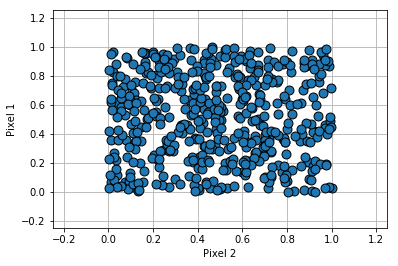

In [3]:
x1 = np.random.uniform(size=500)
x2 = np.random.uniform(size=500)
fig = plt.figure();
ax = fig.add_subplot(1,1,1);
ax.scatter(x1,x2, edgecolor='black', s=80);
ax.grid();
ax.set_axisbelow(True);
ax.set_xlim(-0.25,1.25); ax.set_ylim(-0.25,1.25)
ax.set_xlabel('Pixel 2'); ax.set_ylabel('Pixel 1'); plt.savefig('images_in_2dspace.pdf')

Any one point inside the unit square would represent an image. For example the image associated with the point $(0.25,0.85)$ is shown below.


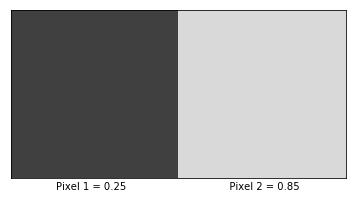

In [51]:
im = [(0.25, 0.85)]
plt.imshow(im, cmap='gray',vmin=0,vmax=1)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    left='off',
    right='off'
)
plt.xticks([])
plt.yticks([])
plt.xlabel('Pixel 1 = 0.25                                 Pixel 2 = 0.85')
plt.savefig('sample_2dspace_image.pdf')

Now consider the case where there is some process correlating the two variables. This would be similar to the underlying biophysics governing the activity of an astrocyte. In that case, the pixels would be correlated in some manner due to the mechanism driving the cell and we would see structure in the microscopy recordings. In this simple case, let's consider a direct correlation of the form $x_1 = \frac{1}{2} \cos(2\pi x_2)+\frac{1}{2}+\epsilon$ where $\epsilon$ is a noise term coming from a low variability normal distribution $\epsilon \sim N(0,\frac{1}{10})$. We see below that in this case, the images plotted in two dimensions resulting from this relationship form a distinct pattern. In addition if we look at the images themselves one may be able to see a pattern...

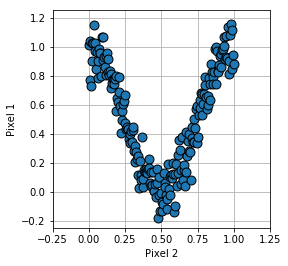

In [30]:
x1 = lambda x2: 0.5*np.cos(2*np.pi*x2)+0.5
x2 = np.linspace(0,1,200)
eps = np.random.normal(scale=0.1, size=200)
fig = plt.figure();
ax = fig.add_subplot(1,1,1);
ax.scatter(x2,x1(x2)+eps, edgecolor='black', s=80);
ax.grid();
ax.set_axisbelow(True);
ax.set_xlim(-0.25,1.25); ax.set_ylim(-0.25,1.25); plt.axes().set_aspect('equal')
ax.set_xlabel('Pixel 2'); ax.set_ylabel('Pixel 1'); plt.savefig('structured_images_in_2dspace.pdf')

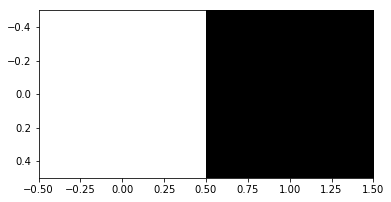

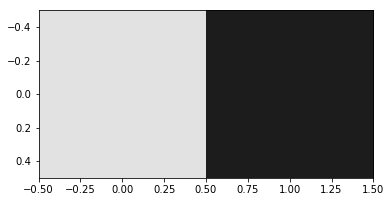

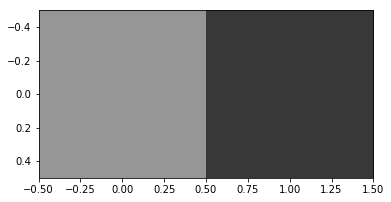

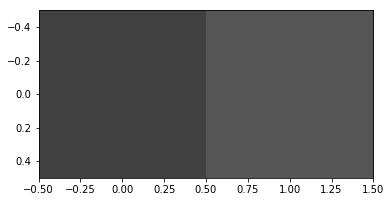

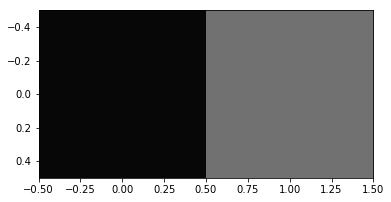

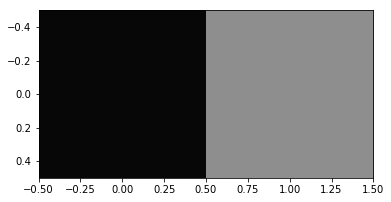

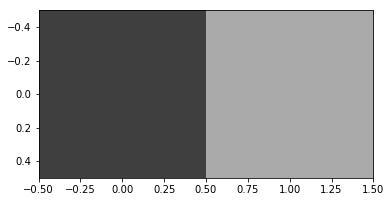

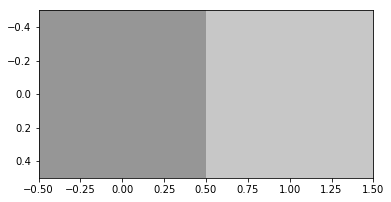

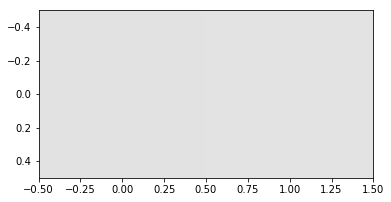

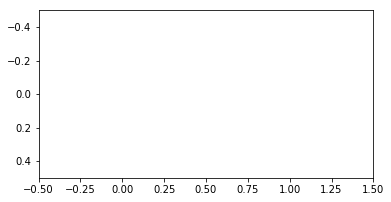

In [28]:
structured_images = zip(x1(np.linspace(0,1,10)), np.linspace(0,1,10))
for im in structured_images:
    plt.figure(); plt.imshow([im], cmap='gray', vmin=0, vmax=1)

We will refer to the structure suggested by the two dimensional points as the 'manifold'. This is a common practice when analyzing images. A 28 by 28 dimensional image will be a point in 784 dimensional space. If we are examining images with structure, various images of the number 2 for example, then it turns out that these images will form a manifold in 784 dimensional space. In most cases, as is the case in our contrived example, this manifold exists in a lower dimensional space than that of the images themselves. The goal is to 'learn' this manifold. In our simple case we can describe the manifold as a function of only 1 variable $$f(t) = <t,\frac{1}{2} \cos(2\pi t)+\frac{1}{2}>$$ This is what we would call the underlying data generating process. In practice we usually describe the manifold in terms of a probability distribution. We will refer to the data generating distribution in our example as $p_{test}(x_1, x_2)$. Why did we choose a probability to describe the manifold created by the data generating process? How might this probability be interpreted?

Learning the actual distribution turns out to be a rather difficult task. Here we will use a common non parametric technique for describing distributions, the histrogram. Looking at a histogram of the images, or two dimensional points, will give us insight into the structure of the distribution from which they came. Notice here though that the histogram merely describes the distribution, we do not know what it is.

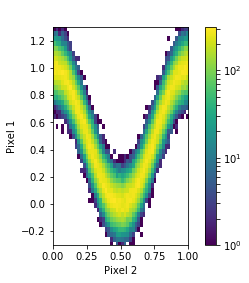

In [33]:
from matplotlib.colors import LogNorm
x2 = np.random.uniform(size=100000)
eps = np.random.normal(scale=0.1, size=100000)
hist2d = plt.hist2d(x2,x1(x2)+eps, bins=50, norm=LogNorm())
plt.xlim(0.0,1.0); plt.ylim(-0.3,1.3); plt.axes().set_aspect('equal')
plt.xlabel('Pixel 2'); plt.ylabel('Pixel 1')
plt.colorbar();
plt.savefig('histogram_of_structured_images.pdf')

As our intuition might have suggested, the data generating distribution looks very similar to the structure suggested by the two dimensional images plotted above. There is high probability very near the actual curve $x_1 = \frac{1}{2} \cos(2\pi x_2)+\frac{1}{2}$ and low probability as we move away. We imposed the uncertainty via the Gaussian noise term $\epsilon$. However, in real data the uncertainty can be due to the myriad of sources outlined above. In these cases a complex probability distribution isn't an arbitrary choice for representing the data, it becomes necessary [cite Cristopher Bishop 2006]. 

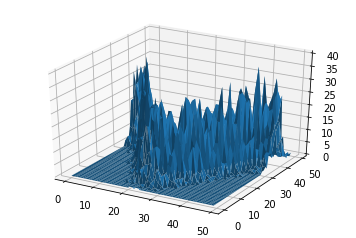

In [12]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
X,Y = np.mgrid[0:50,0:50]
ax.plot_surface(X, Y, hist2d[0])#, linewidth=0, antialiased=False)

Hopefully we're now begining to understand how to interpret $p_{test}(x_1, x_2)$. One might say $p_{test}$ measures how likely a certain configuration of $x_1$ and $x_2$ is to have arisen from the data generating process $f(t)$. Therefore if one can learn the data generating distribution, then they have a descriptive measure of the true underlying data generating process. This intuition extends to the $p_{data}(x)$ for astrocyte observations that was presented above. Next we will explore some techniques for directly learning the data generating distribution from a set of observations.